# NN draw

In [6]:
import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [7]:
from rebayes_mini.methods import low_rank_last_layer as lrll

In [8]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model objective function

In [9]:
class TrueMLP(nn.Module):
    n_hidden: int = 50

    def setup(self):
        self.hidden_1 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x)
        return x

In [10]:
key = jax.random.PRNGKey(314)
key_init, key_surrogate = jax.random.split(key)

In [11]:
dim = 200 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

## Components

In [44]:
def projection(params, hparams):
    return jnp.clip(params, 0.0, 1.0)


def minimise_project(guess_init, params_hidden, params_ll):
    fn_sampled = lambda x: -agent.mean_fn(params_hidden, params_ll, x).squeeze()
    opt = ProjectedGradient(
        fun=fn_sampled,
        projection=projection,  # Enforce boundary constraints
        stepsize=1e-3,
        tol=1e-5,
        maxiter=2000,
    )
    res = opt.run(guess_init)
    return res

def step(state, t, key, agent, guess_init):
    bel, x, y, y_best = state
    key_step = jax.random.fold_in(key, t)
    key_step, key_guess = jax.random.split(key_step)

    guess_init = jax.random.uniform(key_guess, len(x))
    
    ll_params = agent.sample_params_last_layer(key_step, bel).squeeze()
    # compute location of next best estimate and actual estimate
    x_next = minimise_project(guess_init, bel.mean_hidden, ll_params).params
    y_next = base_model.apply(params_base, x_next)
    # update belief based on true observations
    bel = agent.update(bel, y_next.squeeze(), x_next)

    # Update y_best if greater than current query
    y_best = y_next * (y_next > y_best) + y_best * (y_next <= y_best)

    out = {
        "x": x_next.squeeze(),
        "y": y_next.squeeze(),
        "y_best": y_best.squeeze()
    }

    state_next = (bel, x_next, y_next, y_best)
    return state_next, out


def bayesopt_run(key, agent, n_steps, bel_init, objective_fn):
    """
    """
    steps = jnp.arange(n_steps)
    key_init_lr, key_init_x, key_eval, key_guess = jax.random.split(key, 4)

    x_init = jax.random.uniform(key_init_x, (dim))
    # y_init = base_model.apply(params_base, x_init)
    y_init = objective_fn(x_init)

    guess_init = jax.random.uniform(key_guess, dim) # intial guess per run
    _step = partial(step, key=key_eval, agent=agent, guess_init=guess_init)
    state_init = (bel_init, x_init, y_init, y_init)
    bel_final, hist = jax.lax.scan(_step, state_init, steps)

    return hist["y_best"]

## Surrogate model

In [45]:
class MLP(nn.Module):
    n_hidden: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

## Run experiment

In [46]:
key_init_params, key_eval, key_test = jax.random.split(key_surrogate, 3)

In [47]:
%%time
surrogate = MLP()
params_init = surrogate.init(key_init_params, X_init)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=320,
    dynamics_hidden=0.0, dynamics_last=0.0,
)

cov_hidden = 1.0
cov_last = 100.0
n_steps = 600

bel_init = agent.init_bel(
    params_init,
    cov_hidden,
    cov_last,
    low_rank_diag=False,
)

y_best_hist = test_run(key_eval, n_steps, agent, bel_init)
y_best_hist = jax.tree.map(np.array, y_best_hist)

CPU times: user 28.3 s, sys: 641 ms, total: 29 s
Wall time: 23.8 s


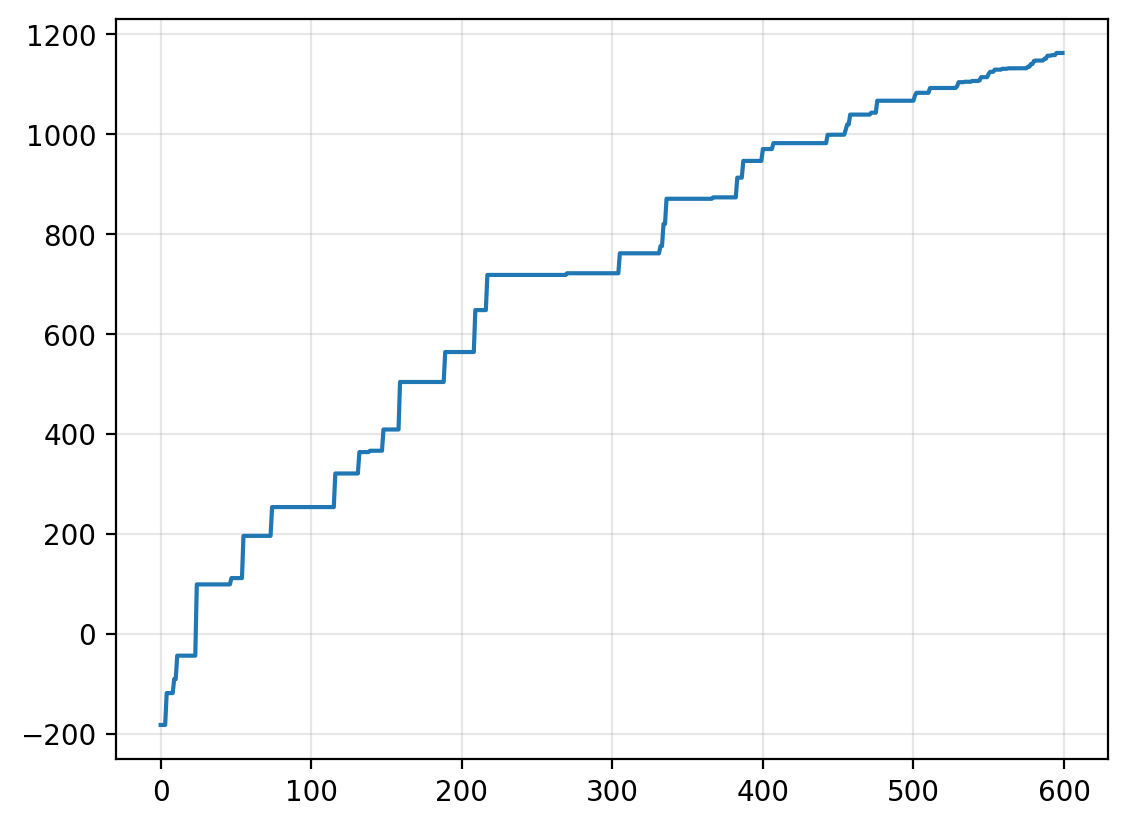

In [48]:
plt.plot(y_best_hist)
plt.grid(alpha=0.3)

## Best optimum (projected gradient descent)

In [49]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=projection,  # Enforce boundary constraints
    stepsize=1e-7,
    maxiter=8000
)

guess_init = jax.random.uniform(key_test, dim) # intial guess per run
res = opt.run(init_params=guess_init)

In [50]:
yopt = base_model.apply(params_base, res.params)
yopt

Array([1195.3282], dtype=float32)

Text(0, 0.5, 'eval fn.')

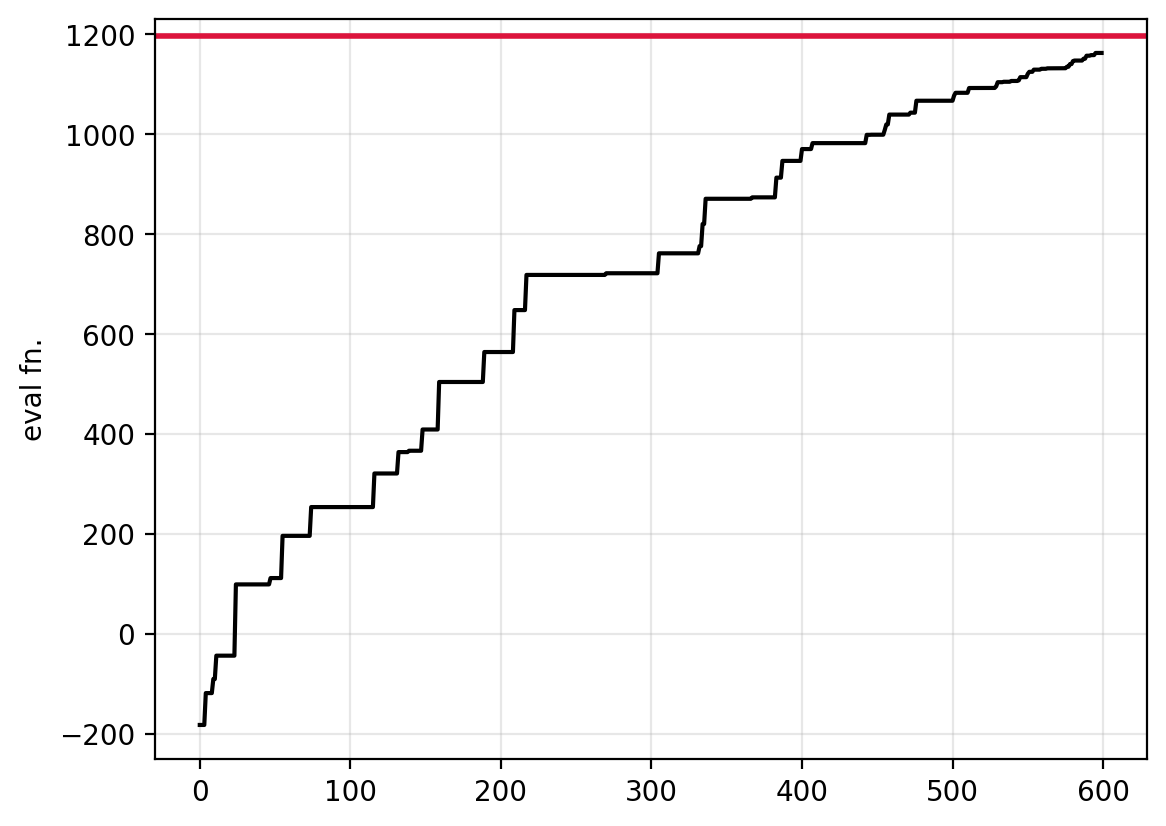

In [51]:
plt.plot(y_best_hist, c="black")
plt.axhline(y=yopt, c="crimson", linewidth=2)
plt.grid(alpha=0.3)
plt.ylabel("eval fn.")